In [1]:
from gensim.models import word2vec
from scipy.spatial import distance
from nltk.corpus import stopwords
import os
from scipy.spatial import distance
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import csv 


/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
raw_df = pd.read_csv(r"shuffled.csv")
raw_df.head()
nltk.download('stopwords')
hindi_stopwords = stopwords.words('hindi')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jathinb/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
Train_data = raw_df[:10000]
Test_data  = raw_df[10000:12642]

In [4]:
def clean_dataframe(data):
    "This function Removes all the documents that doesnot have plots and applies the clean_sentence function to the documents that have plots"	
    data = data.dropna(how='any')#Drops the NaNs occuring in the dataframe 
    data['Summary'] = data['Summary'].apply(clean_sentence)#Applies the clean sentence function
    
    return data


def clean_sentence(val):
    total_count = 0
    count = 0
    "This function Removes all the characters that are not letters or numbers , converts the sentence to lowercase and removes the stopwords occuring in the document"		
    regex = re.compile('([^\s\w]|_)+')#Removes chars that are not letters or numbers
    sentence = regex.sub('', val).lower()#Converts the sentence to lowercase
    sentence = sentence.split(" ")

    for word in list(sentence):
        total_count = total_count + 1
        if word in hindi_stopwords :
            count = count + 1
            sentence.remove(word)#Removes stop words that occur in the sentence  

    sentence = " ".join(sentence)
   # print(total_count,count)
    return sentence

def documentvec(word2vec_model,summarywords):
    "This function Creates a document vector by taking the mean of word vectors of the words in the document"
    k=[]
    for i in range(len(summarywords)): 
        if summarywords[i] in word2vec_model.wv:#model.wv.vocab gives the entire word vocabulary 
            k.append(word2vec_model.wv[summarywords[i]])#of the generated model upon the given dataset
    return np.mean(k,axis=0)


def build_corpus(data):
    "This function Tokenizes all the words in a document's plot and stores them in a list, then it stores all the lists of individual plots into a corpus"
    corpus = []

    for sentence in data['Summary'].iteritems():
        word_list = sentence[1].split(" ")#Tokenizes words of each plot and appends them 
        corpus.append(word_list)#to a list which is further appended to corpus

    return corpus

In [5]:
cleaned_data = clean_dataframe(Train_data)

In [6]:
corpus = build_corpus(cleaned_data)


In [7]:
model = word2vec.Word2Vec(corpus, vector_size=100, window=50, min_count= 1, workers=4)


In [8]:
model.save("word2vec.model")

In [8]:
docvecs=[]
for i in range(len(corpus)): 
        docvecs.append(documentvec(model,corpus[i]))

In [9]:
True_data = []
False_data = []
docvecs2=[]
i = 0
for index,category in cleaned_data.iterrows():
    if category[2] == 1:
        True_data.append(docvecs[index])
    else:
        False_data.append(docvecs[index]) 
    arr_append = np.append(docvecs[index], category[2])
    docvecs2.append(arr_append)

True_vector = np.mean(True_data,axis=0)

False_vector = np.mean(False_data,axis=0)

In [10]:
with open('Vector_list.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
    write.writerows(docvecs2) 

In [11]:
docvecs3=[]
docvecs3.append(True_vector)
docvecs3.append(False_vector)
with open('Final_Vectors.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
    write.writerows(docvecs3) 

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


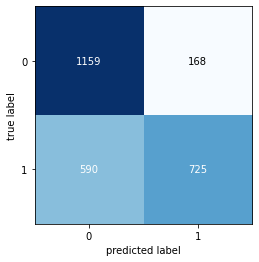

Accuracy   =  0.7130961392884179
Recall     =  0.8733986435568952
Precision  =  0.6626643796455117


In [12]:
TP = 0
TN = 0
FP = 0
FN = 0
for index,row in Test_data.iterrows():
    test_summary = row[1]
    test_summary_words = test_summary.split(' ')
    test_vector = documentvec(model,test_summary_words)
    true_class  = 1 - distance.cosine(test_vector,True_vector)
    false_class  = 1 - distance.cosine(test_vector,False_vector)
    if true_class > false_class:
        category = 1
    else:
        category = 0
    if category == 1 and row[2] == 1:
        TP = TP + 1
    elif category == 0 and row[2] == 1:
        FN = FN + 1
    elif category == 1 and row[2] == 0:
        FP = FP + 1
    else:
        TN = TN + 1
    

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[TP, FN],
                   [FP, TN]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()


Precision  =  (TP / (TP + FP))
Recall     =  (TP / ( TP + FN ))
print("Accuracy   = ", (TP + TN) / (TN + TP + FN + FP))
print("Recall     = ", TP / ( TP + FN ))
print("Precision  = ", TP / (TP + FP))




In [45]:
pca_df = pd.read_csv(r"Vector_list.csv")
pca_df.head()


x = pca_df.iloc[:, 0:100].values 
y = pca_df.iloc[:, 100].values 


# x = StandardScaler().fit_transform(x) # normalizing the features

x.shape

np.mean(x),np.std(x)

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]

normalised_breast = pd.DataFrame(x,columns=feat_cols)

normalised_breast.tail()

from sklearn.decomposition import PCA
pca_breast = PCA(n_components=2)
principalComponents_breast = pca_breast.fit_transform(x)

import pickle as pk
pk.dump(pca_breast, open("pca.pkl","wb"))

principal_breast_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['principal component 1', 'principal component 2'])

principal_breast_Df

print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_))

Explained variation per principal component: [0.17375307 0.10945103]


In [37]:
len(y)

10000

In [38]:
len(principalComponents_breast[0])

2

In [44]:
docvecs2=[]
for index in range(0,1000):
    arr_append = np.append(principalComponents_breast[index], y[index])
    docvecs2.append(arr_append)

    


In [41]:
with open('Vectors_2d.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
    write.writerows(docvecs2) 

In [42]:
pca_df.head()

,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,...,vec91,vec92,vec93,vec94,vec95,vec96,vec97,vec98,vec99,Class
0,-1.597517,3.237337,1.474194,0.894347,0.741606,-0.328466,-0.060693,0.163177,-1.403805,1.785787,...,1.214980,-0.173592,0.692982,2.112439,1.363587,0.984813,0.746048,-0.346703,1.955261,1
1,-0.200600,1.755647,-0.847285,0.251679,1.123263,-1.338974,0.902635,-1.705480,-0.183769,-0.515497,...,-0.011865,-0.322144,0.984330,0.890204,0.470884,0.436083,0.564989,0.548087,1.713523,0
2,-1.410996,3.299382,0.305103,-0.531280,0.687188,0.452532,-0.646133,-1.298153,-1.055596,-0.001914,...,1.624871,0.621559,1.067528,0.967904,1.794135,0.018184,0.026466,0.734895,2.824650,1
3,0.050038,2.165478,-0.570296,-0.282696,2.112467,-0.612395,-1.017420,-1.511361,-1.005908,-0.085347,...,0.251472,-0.057043,1.514397,0.811191,1.030894,-0.097971,-0.406316,1.942172,2.211735,0
4,-0.646970,1.393267,0.197740,0.460789,0.405610,-0.244276,-0.815821,-1.832082,-0.620022,1.394146,...,-0.122732,0.017201,-0.176860,-0.291529,0.883147,0.625056,0.189271,-0.778523,0.984590,0


<Figure size 432x288 with 0 Axes>

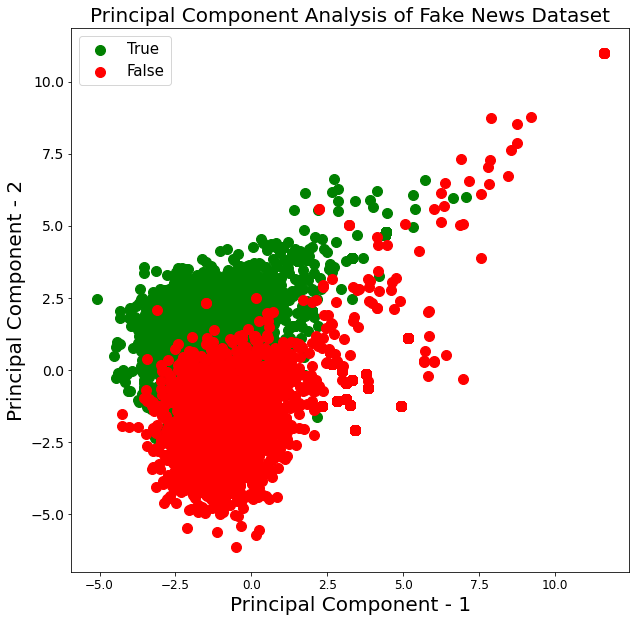

In [43]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Fake News Dataset",fontsize=20)
targets = [1,0]
Classes = ["True","False"]
colors = ['g','r']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['Class'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 100)

plt.legend(Classes,prop={'size': 15})

In [21]:
pca_df = pd.read_csv(r"Vector_list.csv")
pca_df.head()


X = pca_df.iloc[:, 0:100].values 
y = pca_df.iloc[:, 100].values 

In [22]:
feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

In [23]:
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['Class'] = df['y'].apply(lambda i: str(i))


In [24]:
X, y = None, None

In [25]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17378487 0.10942143 0.06395707]


In [26]:
rndperm = np.random.permutation(df.shape[0])

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

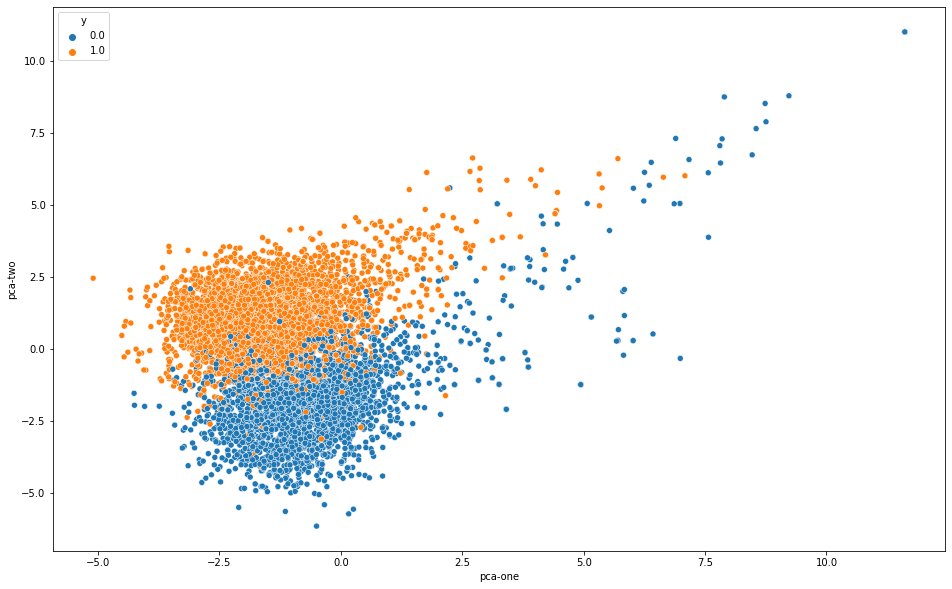

In [27]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    data=df.loc[rndperm,:],
    legend="full",
    alpha = 1

)

In [28]:
from sklearn.decomposition import PCA

In [29]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

/var/folders/fk/6qynqnl56hs0_g38s0gv7w100000gr/T/ipykernel_29828/1801808602.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


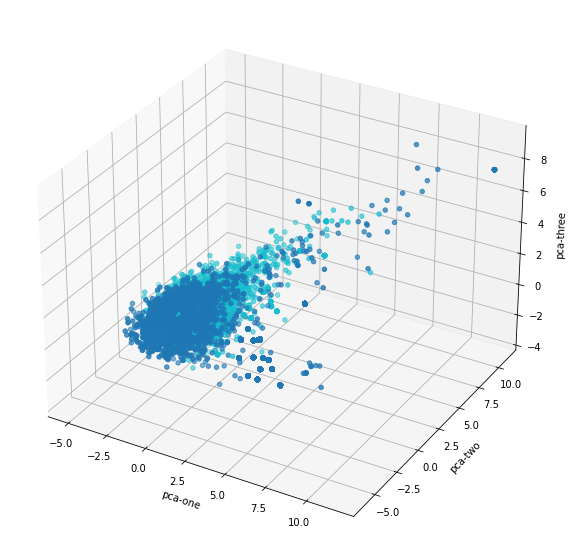

In [30]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [31]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17378487 0.10942143 0.06395707]


In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9999 samples in 0.001s...
[t-SNE] Computed neighbors for 9999 samples in 2.712s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9999
[t-SNE] Computed conditional probabilities for sample 2000 / 9999
[t-SNE] Computed conditional probabilities for sample 3000 / 9999
[t-SNE] Computed conditional probabilities for sample 4000 / 9999
[t-SNE] Computed conditional probabilities for sample 5000 / 9999
[t-SNE] Computed conditional probabilities for sample 6000 / 9999
[t-SNE] Computed conditional probabilities for sample 7000 / 9999
[t-SNE] Computed conditional probabilities for sample 8000 / 9999
[t-SNE] Computed conditional probabilities for sample 9000 / 9999
[t-SNE] Computed conditional probabilities for sample 9999 / 9999
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.624222
[t-SNE] KL divergence after 300 iterations: 2.304636


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

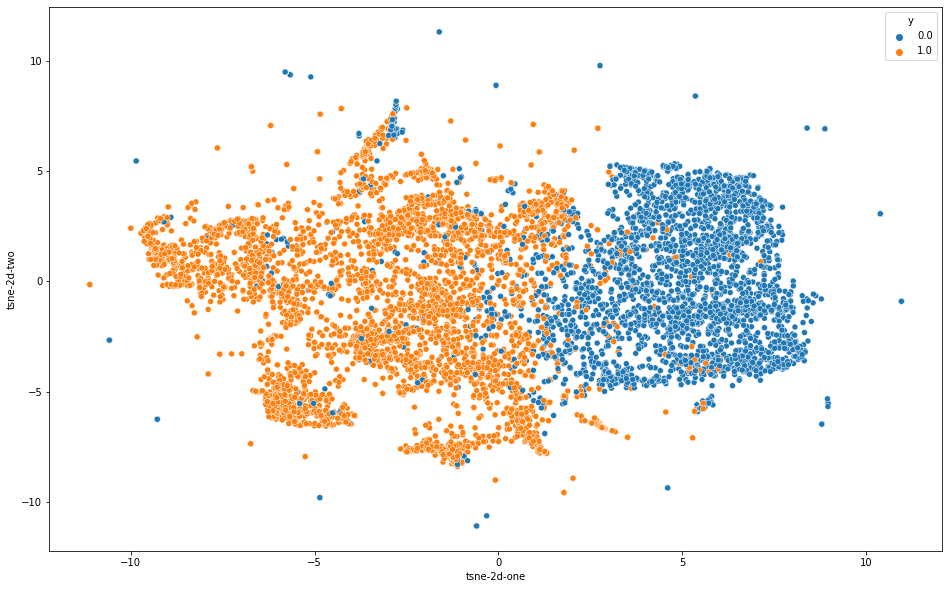

In [33]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=df_subset,
    legend="full",
)

In [54]:
from sklearn.linear_model import LogisticRegression
pca_df = pd.read_csv(r"Vector_list.csv")


In [55]:
x_train  = pca_df.iloc[:, 0:100].values 
y_train  = pca_df.iloc[:, 100].values 



In [56]:
print(x_train[0])
print(y_train[0])
print(len(x_train))
print(len(y_train))

[-0.41702661  2.22310376 -0.40049547  0.77744401  0.87793207  1.51312244
  0.93864036  0.46809617 -0.31972548 -0.64075822 -0.84809923  0.31572312
 -0.79637241 -2.07330608 -0.73363394 -1.73130178 -0.11478107 -0.50776017
 -0.71039528  0.07049455 -0.65200824 -1.07082462  0.01466164 -0.90333331
 -0.37266204  0.98935002  0.16260414  0.16787317 -0.01197258 -0.7516768
 -1.04301918 -1.32977521  0.40680707 -1.47571599 -0.64258015 -1.29405141
 -0.28917441 -0.81741667 -1.07535565  0.59667856 -0.36029077 -0.72416395
  0.95109403  1.31569791  0.3040016  -0.53032333 -0.86403525  0.35591316
 -1.00328302  0.93169492  0.13673714  0.27470651  0.04182514 -0.14328009
  0.02471644 -0.98565936 -0.16508411 -0.71816927  1.30167925 -0.2748104
 -0.08099723  0.10417665  0.89447629 -0.16542113  1.73224008  0.29652536
 -0.65114105  1.42104971  0.07128631 -0.06859741  0.3328349   0.16623046
  0.92345005 -0.25798699 -0.10510964 -1.58913243  1.39797175 -1.01695859
  1.92700756  0.1572856  -0.99136579 -0.05136671  0.2

In [57]:
LR = LogisticRegression()
LR.fit(x_train,y_train)


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [64]:
import joblib
joblib.dump(LR,'LR_W2V.pkl')

['LR_W2V.pkl']

In [33]:
pred_lr=LR.predict(x_test)
LR.score(x_test, y_test)
print(classification_report(y_test, pred_lr))

NameError: name 'x_test' is not defined

In [60]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
import joblib
joblib.dump(DT,'DT_W2V.pkl')

['DT_W2V.pkl']

In [62]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)
import joblib
joblib.dump(RFC,'RFC_W2V.pkl')

['RFC_W2V.pkl']

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(x_train, y_train)
import joblib
joblib.dump(GBC,'GBC_W2V.pkl')

['GBC_W2V.pkl']

In [157]:
from sklearn.metrics import classification_report
pred_dt = DT.predict(x_test)
DT.score(x_test, y_test)


0.6158213474640424

In [158]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1315
           1       0.62      0.61      0.62      1327

    accuracy                           0.62      2642
   macro avg       0.62      0.62      0.62      2642
weighted avg       0.62      0.62      0.62      2642



Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.9
    /usr/local/lib/python3.9/site-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.9/site-packages/numpy/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
